In [101]:
import numpy as np
import pandas as pd
import xgboost
import time
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
ds_train = pd.read_hdf('../data/DS_2_train_extended_float32.hdf')

ds_train.head()
ds_train.columns

,index,event_id,X,Y,Z,TX,TY,chi2,signal,brick_number,...,dR1up,dR1down,dR2up,dR2down,dR3up,dR3down,dR4up,dR4down,dR5up,dR5down
0,0,-999,66162.843750,65620.031250,0.0,0.166890,0.276674,2.988714,0.0,44,...,-999.000000,412.241272,-999.000000,248.789047,-999.000000,553.542969,-999.000000,698.970520,-999.000000,244.996826
1,1,-999,43900.445312,67091.671875,0.0,-0.179967,-0.478795,1.901420,0.0,98,...,-999.000000,1219.330688,-999.000000,909.134155,-999.000000,508.946655,-999.000000,524.939331,-999.000000,642.560852
2,2,-999,37564.019531,26618.890625,55599.0,-0.267820,-0.282087,2.510245,0.0,64,...,831.191528,429.726746,519.746033,179.646698,1469.534790,831.921570,800.664490,1088.205444,887.107056,363.055908
3,3,-999,39380.027344,48135.425781,19395.0,0.265197,-0.577493,1.215219,0.0,63,...,217.105438,772.216370,898.697327,732.458069,567.273071,684.447266,841.417786,1224.376221,413.581573,1006.183350
4,4,-999,65040.781250,44018.468750,12930.0,-0.711161,-0.245592,2.973661,0.0,2,...,449.162842,1232.191406,781.930542,741.583557,1040.501587,420.205811,701.071167,805.463928,238.712112,1295.326904


Index([u'index', u'event_id', u'X', u'Y', u'Z', u'TX', u'TY', u'chi2',
       u'signal', u'brick_number', u'grid_value', u'smoothgrid_value',
       u'dT1up', u'dT1down', u'dT2up', u'dT2down', u'dT3up', u'dT3down',
       u'dT4up', u'dT4down', u'dT5up', u'dT5down', u'dR1up', u'dR1down',
       u'dR2up', u'dR2down', u'dR3up', u'dR3down', u'dR4up', u'dR4down',
       u'dR5up', u'dR5down'],
      dtype='object')

In [121]:
brick_nb = 80

D_train = ds_train[ds_train.brick_number < brick_nb]
D_test = ds_train[ds_train.brick_number >= brick_nb]

X_train = D_train.drop('index', axis=1).drop('event_id', axis=1).drop('signal', axis=1).drop('brick_number', axis=1)
X_test = D_test.drop('index', axis=1).drop('event_id', axis=1).drop('signal', axis=1).drop('brick_number', axis=1)

Y_train = D_train['signal']
Y_test = D_test['signal']

In [122]:
n_est = 32

#model = xgboost.XGBClassifier(n_estimators=n_est, nthread=8, max_depth=2)#, reg_alpha=0, reg_lambda=0.5)
#model = GradientBoostingClassifier(n_estimators=n_est, max_depth=4, loss='exponential')
model = RandomForestClassifier(n_estimators=n_est, max_depth=3, n_jobs=8)
#model = xgboost.XGBClassifier(n_estimators=n_est, nthread=8, max_depth=3)

t1= time.time()
model.fit(X_train, Y_train)
pred_train = model.predict_proba(X_train)[:,1]
pred_test = model.predict_proba(X_test)[:,1]
print 'n_est:', n_est
print 'time taken:', time.time() - t1
print 'train score:', roc_auc_score(Y_train, pred_train)
print 'test score:', roc_auc_score(Y_test, pred_test)
os.system('say "dataset evaluated"')

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=32, n_jobs=8, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

n_est: 32
time taken: 160.130975962
train score: 0.982499325299
test score: 0.985699379226


0

# Show the showers, and background, based on the prediction of the model

/Users/zgubic/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


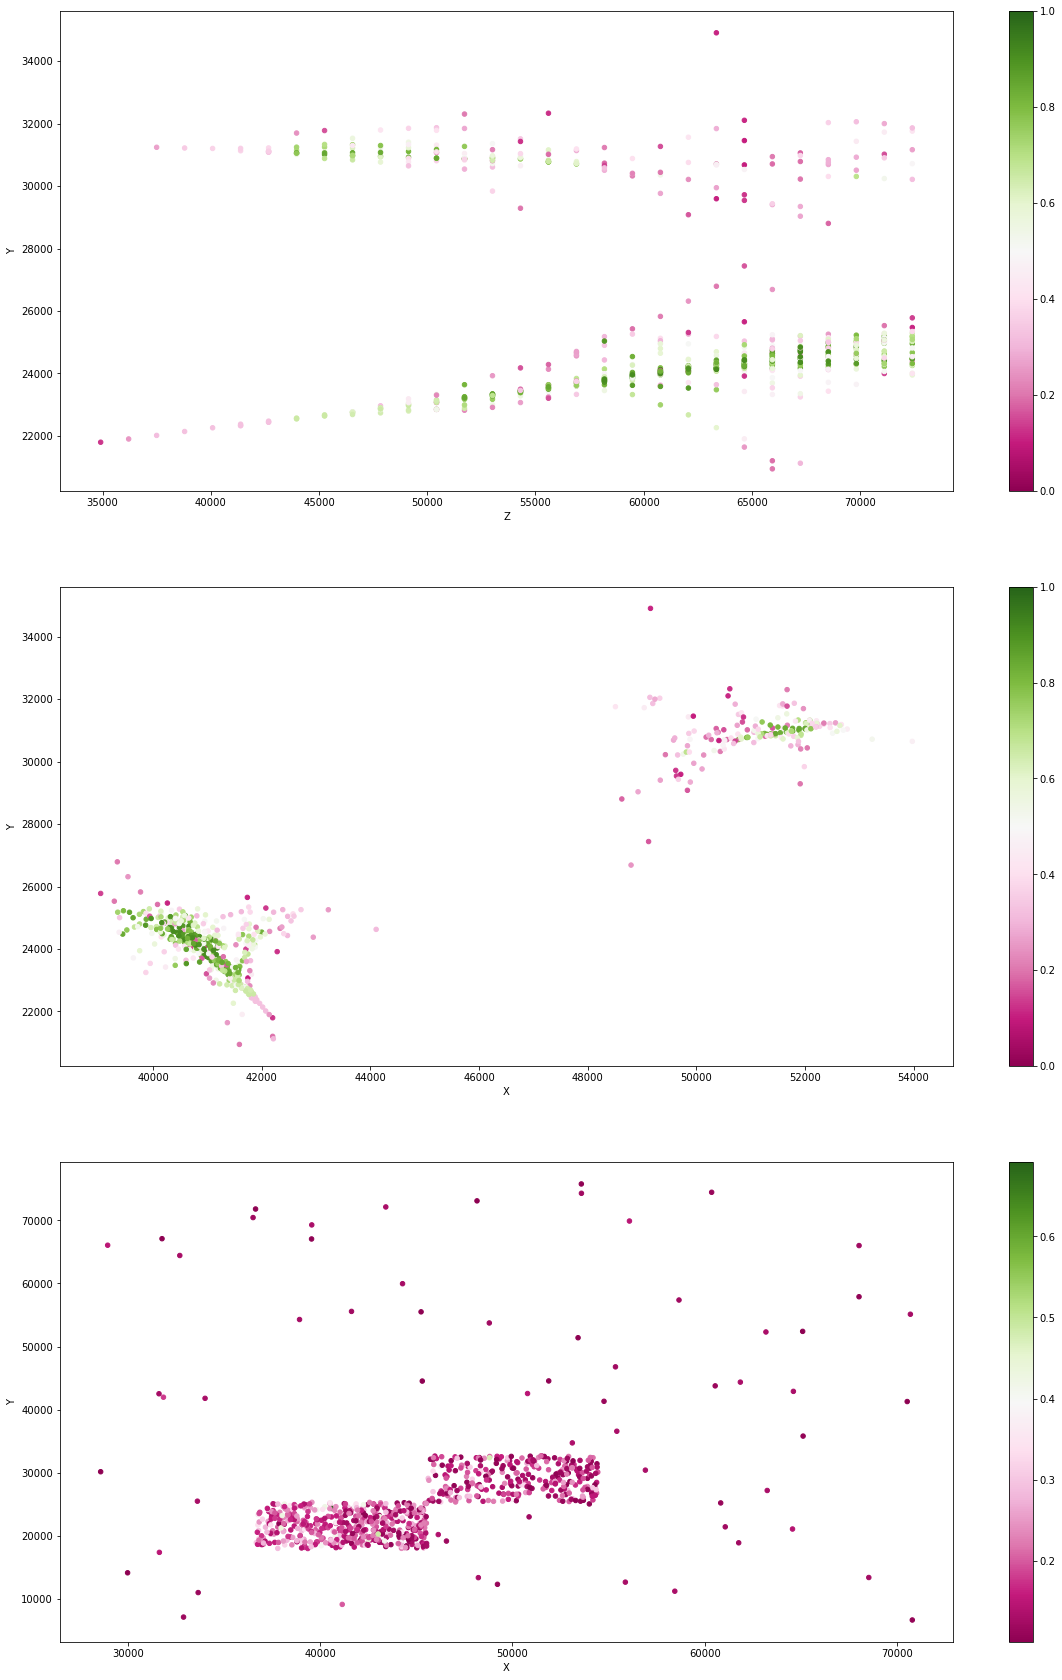

In [139]:
# add the prediction to the data
D_test['prediction'] = pred_test

brick_id = 88
# construct signal and background frames
sig = D_test[(D_test.signal == 1) & (D_test.prediction > 0.1) & (D_test.brick_number == brick_id)]
bkg = D_test[(D_test.signal == 0) & (D_test.prediction > 0.1) & (D_test.brick_number == brick_id)]

# choose a layer
#nlayer = 45
#sig = sig[sig.Z == nlayer*1293]
#bkg = bkg[bkg.Z == nlayer*1293]

# basic plots
fig, ax = plt.subplots(3, figsize=(20, 30))
sig.plot.scatter('Z', 'Y', c=sig.prediction, cmap='PiYG', vmin=0, vmax=1, alpha = 1, ax=ax[0])
sig.plot.scatter('X', 'Y', c=sig.prediction, cmap='PiYG', vmin=0, vmax=1, alpha = 1, ax=ax[1])
bkg.plot.scatter('X', 'Y', c=bkg.prediction, cmap='PiYG', alpha = 1, ax=ax[2])
plt.show()

# Show combined signal and background

It looks like prediction > 0.3 gives a relatively clean shower shape.

/Users/zgubic/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


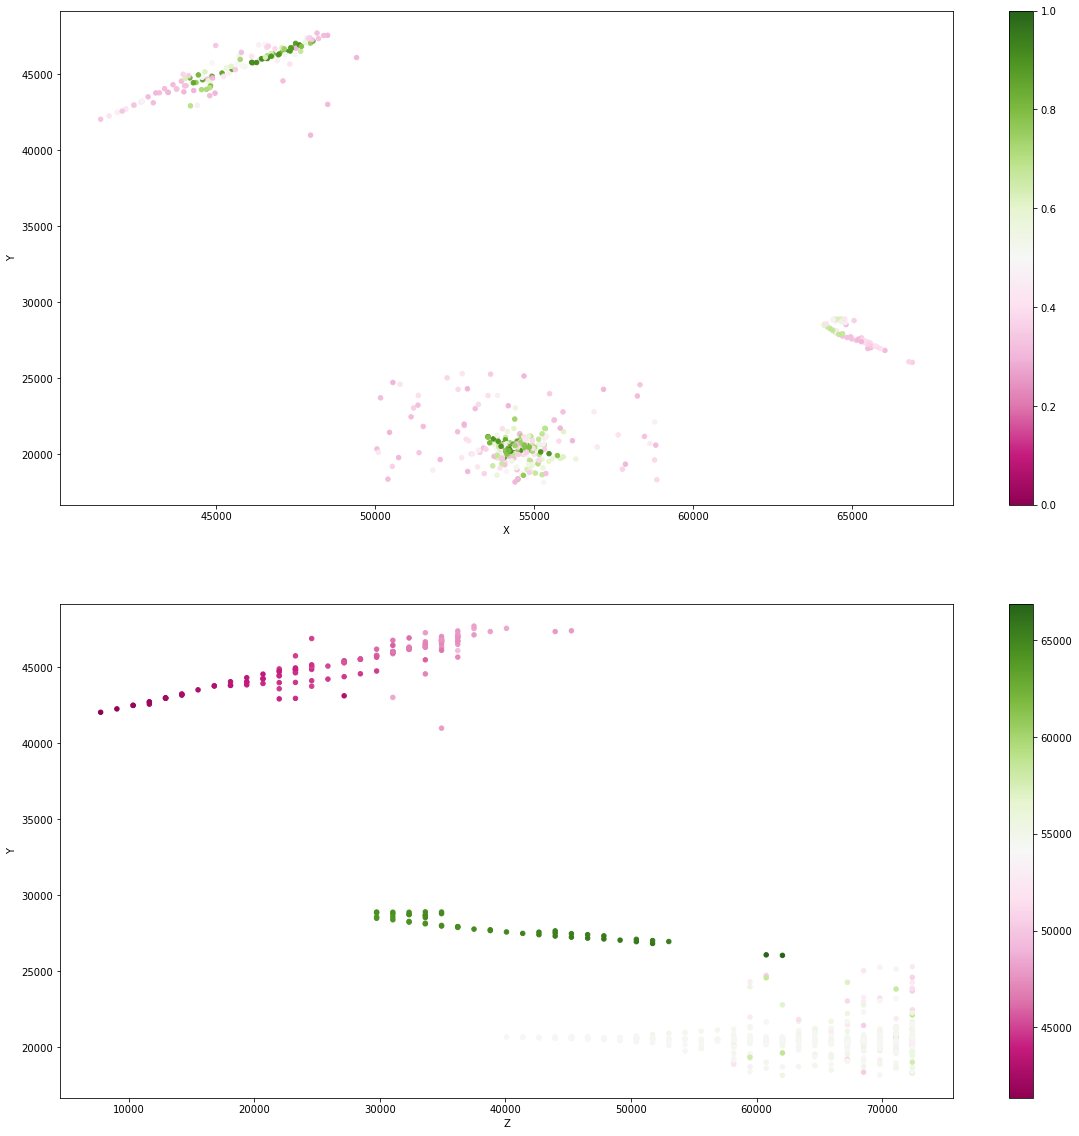

,X,Y
44994,55131.359375,19515.582031
50421,54043.050781,20312.068359
59326,54231.007812,20388.210938
76640,43483.324219,43818.394531
87204,50053.593750,20333.480469


n_clust 2
Silhouette score avg is: 0.877873598683
n_clust 3
Silhouette score avg is: 0.893354445335
n_clust 4
Silhouette score avg is: 0.834073560827
n_clust 5
Silhouette score avg is: 0.712748776537

[ 0.          0.8778736   0.89335445  0.83407356  0.71274878]
x_sd 4913.87064045
y_sd 9764.57445955
standard deviation is: 10931.2871633

###############################
Predicted number of clusters is: 3
###############################


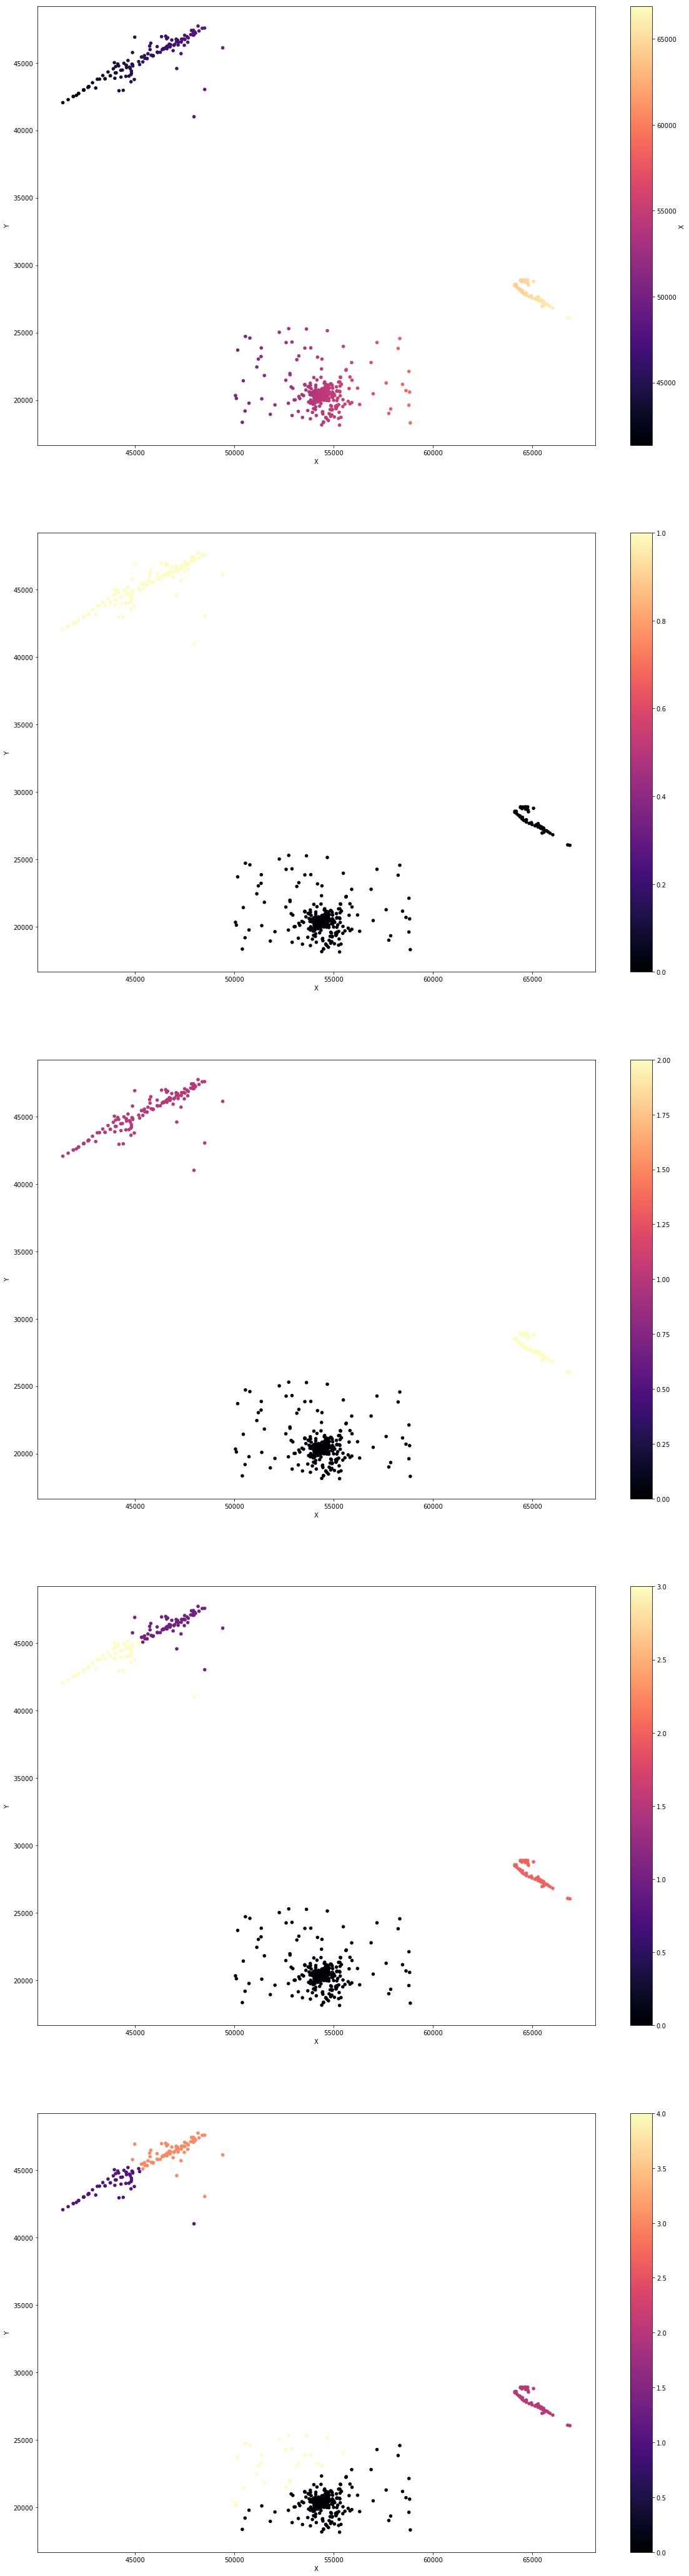

In [186]:
# add the prediction to the data
D_test['prediction'] = pred_test

brick_id = 90
# construct signal and background frames
showers = D_test[(D_test.prediction > 0.3) & (D_test.brick_number == brick_id)]

# basic plots
fig, ax = plt.subplots(2, figsize=(20, 20))
showers.plot.scatter('X', 'Y', c=showers.prediction, cmap='PiYG', vmin=0, vmax=1, alpha = 1, ax=ax[0])
showers.plot.scatter('Z', 'Y', c=showers.X, cmap='PiYG', alpha = 1, ax=ax[1])
plt.show()

# now guess the number of showers
shower_coords = showers[['X', 'Y']]
shower_coords.head()

y_pred = list(range(5))
sil_scores = np.array(range(5), dtype=float)

# compute the kmeans and save the silhouette score
for n_clus in range(2, 6):
    kmeans = KMeans(n_clusters=n_clus)
    y_pred[n_clus-1] = kmeans.fit_predict(shower_coords)
    silhouette_avg = silhouette_score(shower_coords, y_pred[n_clus-1])
    sil_scores[n_clus-1] = silhouette_avg
    print 'n_clust', n_clus
    print "Silhouette score avg is:", sil_scores[n_clus-1]

# determine the number of clusters
pred_number = np.argmax(sil_scores)+1
x_sd = np.std(showers['X'])
y_sd = np.std(showers['Y'])
sdev = np.sqrt(x_sd**2+y_sd**2)

# correct for the 2/1 cluster case
if pred_number == 2 and sdev < 5000:
    pred_number = 1

# let us know the outcome
print 
print sil_scores
print 'x_sd', x_sd
print 'y_sd', y_sd
print 'standard deviation is:', sdev
print
print '###############################'
print 'Predicted number of clusters is:', pred_number
print '###############################'

# basic plots
fig, ax = plt.subplots(5, figsize=(20, 75))
for n_clus in range(1,6):
    shower_coords.plot.scatter('X', 'Y', c=y_pred[n_clus-1], cmap='magma', alpha = 1, ax=ax[n_clus-1])
    
plt.show()

In [198]:
test = D_test[:]

In [199]:
test['X'] = test['X'].astype(np.float32)

In [219]:
a = np.array([1,5,7,2,1.4,0,6,2.2,0.5, 0.7])
a
np.partition(a, 1)[1]

array([ 1. ,  5. ,  7. ,  2. ,  1.4,  0. ,  6. ,  2.2,  0.5,  0.7])

0.5